## A Battle of Neighbors

This is the capstone project for IMB Data Science Professional Certificate for Coursera.

### Intoduction
New York City (NYC) and Tokyo -- two major international megacities. <br/>
<br/>
They share many characteristics. First, of course they are all densily populated! NYC has more than 8 million residents with population density around 30000 per mile. Japan has 13 million residents, and the population density is about half of NYC. In terms of living quality, both cities have convenient public transportation stystems, adequate schools and good public cares. Speaks of environment, they are all accessible to seaside beaches, with similar temperature and humidity rate all year around. What's the difference? <br/>
<br/>
NYC is a multi-cultural city, known for its boroughs and the cultures of individual neighborhoods. English the the spoken language for business. The boroughs include Manhattan, Queens, Brooklyn, Staten Island, and the nearby cities of Long Island. It is so spreadout that often when people refers to 'city' they just mean Manhattan. Within these boroughs, NYC can be divided into neighborhoods like Chinatown and Wallstreet, which are very distinct in nature. They have different life styles and cultures, populated by people with different ethinities. Indeed, 40 percent of the NYC population was born outside of the United States who speaks more than 200 languages. They can all find their little ilands here. NYC is truely a ever-changing rainbow of worlds. <br/>
<br/>

Tokyo, on the other hand, is divided up into various districts called ‘wards’. Even with growing number of people communicating in English, Japanese is still essential for living in Tokyo. It is more famous for its cultural landmarks than its diversity. It is renown for being an in-gathering of Japanese citizens from all over the country. This is because the city population is still around 90% Japanese, and many businesspeople and tourists who have lived there are only temporary residents. It is highly likely that people will be shockedby the stoic silence on the trains, the inevitable languange barrier, and the differences in cultural etiquette when first come to Tokyo. However, with growing business and uniquenss of it, Tokyo now attract more and more global citizens. 
<br/>


### Business Problem

Since these cities have some similarities and some striking differences, one interesting thing to compare is that:
How similar/disimilar are they in terms of neighborhood categories? We will run a distance analysis between neighborhoods clusters and see which neighborhoods in Manhattan is the most similar to Tokyo. This analysis will provide a guideline for successful busniess owners in either city if they want to open a new business in another one.

In this project we will next move on to a more specific topic -- Finding an optimal location for a family-style Chinese restaurant we want to open in both **Manhattan** and **Tokyo**.

Since there are lots of restaurants in both cities we will try to detect **locations that are not already crowded with restaurants**. We are also particularly interested in **areas with no Chinese restaurants in vicinity**. We would also prefer locations **as close to city center as possible**, assuming that first two conditions are met.

We will use our data science powers to generate a few most promissing neighborhoods based on this criteria. Advantages of each area will then be clearly expressed so that best possible final location can be chosen by stakeholders.

In [138]:
# Import packages
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 

import getpass
import geopandas

from sklearn.cluster import KMeans 
from sklearn import metrics 

# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize
import folium # plotting library

import matplotlib.pyplot as plt
import seaborn as sns


import matplotlib.cm as cm
import matplotlib.colors as colors

In [2]:
%matplotlib inline
sns.set_style('white')

### Data

Based on definition of our problem, factors that will influence our decission are:
* number of existing restaurants in the neighborhood (any type of restaurant)
* number of and distance to Chinese restaurants in the neighborhood, if any
* distance of neighborhood from city center

Following data sources will be needed to extract/generate the required information:
* centers of candidate areas will be generated algorithmically and approximate addresses of centers of those areas will be obtained using **Geopy**
* number of restaurants and their type and location in every neighborhood will be obtained using **Foursquare API**

### Neighborhood similarity

In this session, we will use the boroughs data for NYC provided by IBM capstone project, including the boroughs, neighborhoods and their coordinates.
For Tokyo, we scripted the infomation from wiki (https://en.wikipedia.org/wiki/Special_wards_of_Tokyo) and get the coordinates of each wards use geopy.geolocator.

The manhattan data:

In [3]:
df_manhattan = pd.read_csv('manhattan_data.csv')
df_manhattan.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


The Tokyo data:

In [4]:
df_tokyo = pd.read_csv('tokyo_data.csv')
df_tokyo.head()

,Wards,City,Latitude,Longitude,Population,Area
0,Chiyoda,Tokyo,35.677769,139.764636,"59,441.00",11.66
1,Chūō,Tokyo,35.666255,139.775565,"147,620.00",10.21
2,Minato,Tokyo,35.643227,139.740055,"248,071.00",20.37
3,Shinjuku,Tokyo,35.688364,139.699075,"339,211.00",18.22
4,Bunkyō,Tokyo,35.705571,139.751970,"223,389.00",11.29


#### Neighborhood venue information using Foursquare
Next we want to obtain the venue information for each neighborhoods/wards in Manhattan and Tokyo respectively. Using a free open source API Foursquare.

In [5]:
CLIENT_ID = getpass.getpass()

········


In [6]:
CLIENT_SECRET = getpass.getpass()

········


In [7]:
VERSION = '20200601' # Foursquare API version

In [8]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [9]:
def getNearbyVenues(neighborhood, latitudes, longitudes, radius=2000, LIMIT=100):
    '''This function get venues information from Foursauqre API
        Args:
        neighborhood, lat, lng: Neighborhood name, latitudes, longitudes
        Radius: analysis distance radius
        LIMIT: how many venues get returned
        Returns:
        df: neighborhood name, lat, long, venue name, lat, log, category, distance to center
    '''
    venues_list=[]
    for neighborhood, lat, lng in zip(neighborhood, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']
        
            # return only relevant information for each nearby venue
            venues_list.append([(
                neighborhood, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],
                v['venue']['categories'][0]['name'],
            v['venue']['location']['distance']) for v in results])

            nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
            nearby_venues.columns = ['Neighborhood', 
                          'Neighborhood Latitude', 
                          'Neighborhood Longitude', 
                          'Venue', 
                          'Venue Latitude', 
                          'Venue Longitude',
                          'Venue Category',
                          'Venue Distance']
        except KeyError:
            continue
    
    return nearby_venues

We will first run through all Manhattan neighborhoods, the default 2000, and maximum venues we set to return is 100.

In [10]:
# run through the df_merge get neighborhoods for all neighborhood
# type your answer here
manhattan_venues = getNearbyVenues(neighborhood=df_manhattan['Neighborhood'],
                                   latitudes=df_manhattan['Latitude'],
                                   longitudes=df_manhattan['Longitude']
                                  )

In [11]:
manhattan_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Distance
0,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio,376
1,Marble Hill,40.876551,-73.91066,Sam's Pizza,40.879435,-73.905859,Pizza Place,516
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner,452
3,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place,240
4,Marble Hill,40.876551,-73.91066,The Bronx Public,40.878377,-73.903481,Pub,637


In [12]:
# check unique categories of all venues
print('There are {} uniques categories.'.format(len(manhattan_venues['Venue Category'].unique())))

There are 252 uniques categories.


Next we will run through all Tokyo wards and get the venue information.

In [13]:
# run through the df_merge get neighborhoods for all wars
# type your answer here
tokyo_venues = getNearbyVenues(neighborhood=df_tokyo['Wards'],
                                   latitudes=df_tokyo['Latitude'],
                                   longitudes=df_tokyo['Longitude']
                                  )

In [14]:
tokyo_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Distance
0,Chiyoda,35.677769,139.764636,Keiyō Line Tōkyō Station (京葉線 東京駅),35.677727,139.764848,Train Station,19
1,Chiyoda,35.677769,139.764636,KITTE Garden (屋上庭園 KITTEガーデン),35.679654,139.765169,Roof Deck,215
2,Chiyoda,35.677769,139.764636,Mitsubishi Ichigokan Museum (三菱一号館美術館),35.678420,139.763260,Art Museum,144
3,Chiyoda,35.677769,139.764636,Indian Curry (インデアンカレー),35.678395,139.765008,Japanese Curry Restaurant,77
4,Chiyoda,35.677769,139.764636,Cotton Club,35.678733,139.765231,Jazz Club,120


In [15]:
# check unique categories of all venues
print('There are {} uniques categories.'.format(len(tokyo_venues['Venue Category'].unique())))

There are 237 uniques categories.


#### KMeans clustering using category information

First, we will use onehot encoding to analyze venue categories for each neighborhood.

In [16]:
# one hot encoding
tokyo_onehot = pd.get_dummies(tokyo_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
tokyo_onehot['Neighborhood'] = tokyo_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [tokyo_onehot.columns[-1]] + list(tokyo_onehot.columns[:-1])
tokyo_onehot = tokyo_onehot[fixed_columns]

In [17]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category.

In [18]:
tokyo_grouped = tokyo_onehot.groupby('Neighborhood').mean().reset_index()
tokyo_grouped.head()

,Neighborhood,ATM,Accessories Store,American Restaurant,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Vietnamese Restaurant,Wagashi Place,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Yakitori Restaurant,Yoga Studio,Yoshoku Restaurant
0,Adachi,0.0,0.0,0.00,0.0,0.01,0.00,0.00,0.0,0.0,...,0.0,0.01,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.01
1,Akabane,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,...,0.0,0.01,0.0,0.00,0.00,0.0,0.01,0.01,0.0,0.00
2,Bunkyō,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,...,0.0,0.01,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.01
3,Chiyoda,0.0,0.0,0.01,0.0,0.00,0.02,0.01,0.0,0.0,...,0.0,0.01,0.0,0.01,0.01,0.0,0.00,0.02,0.0,0.02
4,Chūō,0.0,0.0,0.01,0.0,0.00,0.00,0.00,0.0,0.0,...,0.0,0.01,0.0,0.01,0.00,0.0,0.00,0.01,0.0,0.01


In [19]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped.head()

,Neighborhood,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,...,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Battery Park City,0.0,0.00,0.01,0.01,0.0,0.0,0.00,0.01,0.00,...,0.00,0.01,0.0,0.0,0.0,0.00,0.01,0.0,0.00,0.00
1,Carnegie Hill,0.0,0.00,0.03,0.00,0.0,0.0,0.00,0.00,0.04,...,0.00,0.00,0.0,0.0,0.0,0.01,0.03,0.0,0.00,0.02
2,Central Harlem,0.0,0.01,0.03,0.00,0.0,0.0,0.00,0.00,0.01,...,0.00,0.00,0.0,0.0,0.0,0.03,0.01,0.0,0.00,0.04
3,Chelsea,0.0,0.00,0.02,0.00,0.0,0.0,0.00,0.03,0.01,...,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.03
4,Chinatown,0.0,0.00,0.00,0.01,0.0,0.0,0.01,0.00,0.00,...,0.01,0.00,0.0,0.0,0.0,0.01,0.02,0.0,0.01,0.01


Next we will use KMeans to segement the data into clusters. We will first determine how many clusters we should choose using elbow methods.

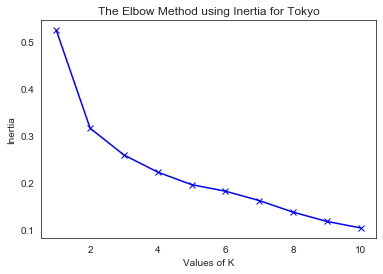

In [20]:
# optimal clusters for Tokyo
inertias = [] 
K = range(1,11) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(tokyo_grouped.iloc[:, 1:])   
    inertias.append(kmeanModel.inertia_) 

plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia for Tokyo') 
plt.show() 

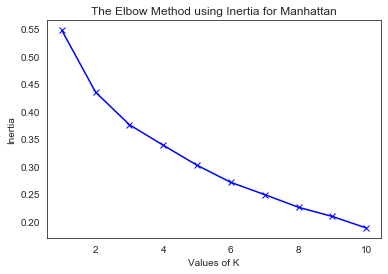

In [21]:
# optimal clusters for Manhattan
inertias = [] 
K = range(1,11) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(manhattan_grouped.iloc[:, 1:])   
    inertias.append(kmeanModel.inertia_) 

plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia for Manhattan') 
plt.show() 

Based on the results, we will choose **3 clusters for Tokyo** and **5 clusters for Manhattan**. We will first analyze Tokyo data.

In [22]:
# set number of clusters
tokyo_grouped_clustering = tokyo_grouped.drop('Neighborhood', 1)
# run k-means clustering
kmeans = KMeans(n_clusters=3, random_state=0).fit(tokyo_grouped_clustering)
# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20] 

array([1, 0, 0, 2, 2, 1, 1, 1, 2, 1, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2],
      dtype=int32)

In [23]:
tokyo_grouped['cluster'] = kmeans.labels_

In [24]:
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
tokyo_merge = pd.merge(df_tokyo, tokyo_grouped, left_on='Wards', right_on='Neighborhood').drop('Neighborhood', 1)

tokyo_merge.head() # check the last columns!

,Wards,City,Latitude,Longitude,Population,Area,ATM,Accessories Store,American Restaurant,Aquarium,...,Wagashi Place,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Yakitori Restaurant,Yoga Studio,Yoshoku Restaurant,cluster
0,Chiyoda,Tokyo,35.677769,139.764636,"59,441.00",11.66,0.0,0.0,0.01,0.0,...,0.01,0.0,0.01,0.01,0.0,0.0,0.02,0.00,0.02,2
1,Chūō,Tokyo,35.666255,139.775565,"147,620.00",10.21,0.0,0.0,0.01,0.0,...,0.01,0.0,0.01,0.00,0.0,0.0,0.01,0.00,0.01,2
2,Minato,Tokyo,35.643227,139.740055,"248,071.00",20.37,0.0,0.0,0.00,0.0,...,0.02,0.0,0.00,0.00,0.0,0.0,0.03,0.00,0.00,0
3,Shinjuku,Tokyo,35.688364,139.699075,"339,211.00",18.22,0.0,0.0,0.00,0.0,...,0.00,0.0,0.00,0.01,0.0,0.0,0.00,0.01,0.01,2
4,Bunkyō,Tokyo,35.705571,139.751970,"223,389.00",11.29,0.0,0.0,0.00,0.0,...,0.01,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.01,0


Next we want to visualize the clusters in a folium map.

In [236]:
# get tokyo lat and lon
address = 'Tokyo, Japan'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

35.6828387 139.7594549


In [237]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(3)
ys = [i + x + (i*x)**2 for i in range(3)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tokyo_merge['Latitude'], tokyo_merge['Longitude'], tokyo_merge['Wards'], tokyo_merge['cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [258]:
# check cluster 0 first
tokyo_c0 = tokyo_onehot[tokyo_onehot.Neighborhood.isin(tokyo_merge[tokyo_merge.cluster == 0].Wards.values)].groupby('Neighborhood').mean().mean()
print('cluster 0 (red):')
tokyo_c0.sort_values(ascending=False)[:5]

cluster 0 (red):


Ramen Restaurant       0.079
Sake Bar               0.077
Café                   0.053
Japanese Restaurant    0.046
BBQ Joint              0.038
dtype: float64

In [244]:
# check cluster 1
tokyo_c1 = tokyo_onehot[tokyo_onehot.Neighborhood.isin(tokyo_merge[tokyo_merge.cluster == 1].Wards.values)].groupby('Neighborhood').mean().mean()
print('cluster 2 (blue):')
tokyo_c1.sort_values(ascending=False)[:5]

cluster 2 (blue):


Convenience Store    0.214
Ramen Restaurant     0.076
Discount Store       0.036
Grocery Store        0.034
Supermarket          0.032
dtype: float64

In [259]:
# check cluster 2
tokyo_c2 = tokyo_onehot[tokyo_onehot.Neighborhood.isin(tokyo_merge[tokyo_merge.cluster == 2].Wards.values)].groupby('Neighborhood').mean().mean()
print('cluster 1 (green):')
tokyo_c2.sort_values(ascending=False)[:5]

cluster 1 (green):


Japanese Restaurant    0.052857
Sushi Restaurant       0.038571
Hotel                  0.037143
Dessert Shop           0.035714
Sake Bar               0.030000
dtype: float64

**SUMMARY** <br/>
From the map, we can see an interesting pattern that the clusters is formed almost surround the center of the city. The 'inner circle' includes famous wards like Shinjuku and Shibuya. The 'middle circle' are the west wards next to 'inner circle', such as Sugumani and Setagaya. Some northeastern wards form a cluster, including Kitasenju and Tateishi etc.

To further explore, we can examine what's the most popular vanue categories within each cluster.
It is interesting to see that the cluster 0 (inner circle) has a lot japanese restaurants, hotels, sushi restaurants. The middle circle, however, contains a lot of ramen restaurants, sake bar, cafe and bbq joints. The northestern cluster has convenience stores (most prominent). 

Probably because the city center are where most short-term vistors stay, so that hotels and japanese restaurants are more popular. However, in a more 'suburb' locations, convenient joints like ramen and sake are more popular, because it is cheaper and faster for daily workers. In a more distant location, it make sense has more covenient stores instead of bars/hotels etc.

Next we will look at Manhattan data.

In [30]:
# set number of clusters
mahattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)
# run k-means clustering
kmeans = KMeans(n_clusters=5, random_state=0).fit(mahattan_grouped_clustering)
# check cluster labels generated for each row in the dataframe
manhattan_grouped['cluster'] = kmeans.labels_

In [31]:
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
manhattan_merge = pd.merge(df_manhattan, manhattan_grouped, on='Neighborhood')
manhattan_merge.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,...,Volleyball Court,Warehouse Store,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,cluster
0,Manhattan,Marble Hill,40.876551,-73.910660,0.0,0.00,0.01,0.00,0.0,0.00,...,0.0,0.01,0.0,0.00,0.02,0.02,0.01,0.00,0.02,3
1,Manhattan,Chinatown,40.715618,-73.994279,0.0,0.00,0.00,0.01,0.0,0.00,...,0.0,0.00,0.0,0.00,0.01,0.02,0.00,0.01,0.01,0
2,Manhattan,Washington Heights,40.851903,-73.936900,0.0,0.00,0.01,0.00,0.0,0.01,...,0.0,0.00,0.0,0.00,0.02,0.03,0.00,0.00,0.00,3
3,Manhattan,Inwood,40.867684,-73.921210,0.0,0.00,0.02,0.00,0.0,0.00,...,0.0,0.00,0.0,0.00,0.04,0.03,0.00,0.00,0.02,3
4,Manhattan,Hamilton Heights,40.823604,-73.949688,0.0,0.01,0.02,0.00,0.0,0.01,...,0.0,0.00,0.0,0.01,0.01,0.01,0.00,0.00,0.03,4


In [32]:
# get Manhattan lat and lon
address = 'Manhattan, New York City'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

40.7810178 -73.959299675


In [33]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(5)
ys = [i + x + (i*x)**2 for i in range(5)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merge['Latitude'], manhattan_merge['Longitude'], manhattan_merge['Neighborhood'], manhattan_merge['cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

We can again see that the clusters are geographically seperated. It is consistent with people's veiw of NYC that culture/life style is largely seperated by neighborhoods. 

In [245]:
# check cluster 0 first
manhattan_c0 = manhattan_onehot[manhattan_onehot.Neighborhood.isin(manhattan_merge[manhattan_merge.cluster == 0].Neighborhood.values)].groupby('Neighborhood').mean().mean()
print('cluster 0 (red):')
manhattan_c0.sort_values(ascending=False)[:5]

cluster 0 (red):


Pizza Place    0.035556
Café           0.028889
Hotel          0.026667
Coffee Shop    0.024444
Bakery         0.024444
dtype: float64

In [246]:
# check cluster 1 first
manhattan_c1 = manhattan_onehot[manhattan_onehot.Neighborhood.isin(manhattan_merge[manhattan_merge.cluster == 1].Neighborhood.values)].groupby('Neighborhood').mean().mean()
print('cluster 1 (purple):')
manhattan_c1.sort_values(ascending=False)[:5]

cluster 1 (purple):


Theater                 0.133333
Park                    0.041667
Gym                     0.031667
Hotel                   0.031667
Gym / Fitness Center    0.028333
dtype: float64

In [36]:
# check cluster 2 first
manhattan_c2 = manhattan_onehot[manhattan_onehot.Neighborhood.isin(manhattan_merge[manhattan_merge.cluster == 2].Neighborhood.values)].groupby('Neighborhood').mean().mean()
manhattan_c2.sort_values(ascending=False)[:5]

Park                    0.066923
Coffee Shop             0.036923
Bakery                  0.032308
Gym / Fitness Center    0.031538
Gym                     0.028462
dtype: float64

In [247]:
# check cluster 3 first
manhattan_c3 = manhattan_onehot[manhattan_onehot.Neighborhood.isin(manhattan_merge[manhattan_merge.cluster == 3].Neighborhood.values)].groupby('Neighborhood').mean().mean()
print('cluster 3 (green):')
manhattan_c3.sort_values(ascending=False)[:5]

cluster 3 (green):


Pizza Place                  0.063333
Mexican Restaurant           0.060000
Park                         0.056667
Latin American Restaurant    0.043333
Café                         0.040000
dtype: float64

In [38]:
# check cluster 4 first
manhattan_c4 = manhattan_onehot[manhattan_onehot.Neighborhood.isin(manhattan_merge[manhattan_merge.cluster == 4].Neighborhood.values)].groupby('Neighborhood').mean().mean()
manhattan_c4.sort_values(ascending=False)[:5]

Park                  0.070000
Coffee Shop           0.064444
Italian Restaurant    0.043333
Pizza Place           0.032222
Bar                   0.031111
dtype: float64

**SUMMARY** <br/>
We can see that cluster 0 (lower west, upper east) near wall street and residential area, has parks, coffee shops, gyms and bakeries. Cluster 1 (upper west), which is acturally seperated from the main island, has mexican and latin american resturants, corresponding to it's ethinicity (majority latino/hispanic). Cluster 2 includes neighborhood like little italy, and hipster region like Soho. Indeed, the neighorhoods are clustered with Pizza and new american restaurants. Cluster 3 (mid-town) contains a lot of gyms, parks, theaters and hotels. Cluster 4 is the upper west, with a lot of residents, contains bars, coffee shops, italian restuarants and pizza places.

We see some interesting cluster patterns for both Tokyo and Manhattan. Next we want to look at which neighborhoods are more similar to each other.

In order to analyze this, we will first find the common categories for both cities. 

In [253]:
common_col = np.intersect1d(tokyo_onehot.columns[1:].values, manhattan_onehot.columns[1:].values)
len(common_col)

154

In [40]:
# create common values for 
tokyo_common = tokyo_merge[common_col]
tokyo_common['cluster'] = tokyo_merge['cluster']
manhattan_common = manhattan_merge[common_col]
manhattan_common['cluster'] = manhattan_merge['cluster']

/Users/xiyuewang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/xiyuewang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [41]:
# get the mean values for category frequency each cluster 
tokyo_cluster_mean = tokyo_common.groupby('cluster').mean()
manhattan_cluster_mean = manhattan_common.groupby('cluster').mean()

In [42]:
tokyo_cluster_mean

,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bagel Shop,...,Train Station,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.002000,0.001,0.001,0.000000,0.001,0.001,0.000,0.000000,0.038000,0.001000,...,0.000000,0.012000,0.001,0.005000,0.000,0.000000,0.002000,0.002,0.002,0.000000
1,0.000000,0.008,0.002,0.000000,0.000,0.002,0.002,0.000000,0.018000,0.000000,...,0.010000,0.010000,0.000,0.002000,0.002,0.000000,0.000000,0.000,0.000,0.000000
2,0.005714,0.000,0.010,0.008571,0.000,0.000,0.000,0.005714,0.017143,0.001429,...,0.004286,0.005714,0.000,0.002857,0.000,0.005714,0.005714,0.000,0.000,0.001429


In [43]:
manhattan_cluster_mean

,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bagel Shop,...,Train Station,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.007778,0.002222,0.006667,0.000000,0.000000,0.012222,0.000000,0.006667,0.007778,0.010000,...,0.000000,0.003333,0.010000,0.011111,0.000000,0.000000,0.021111,0.018889,0.000000,0.006667
1,0.015000,0.001667,0.016667,0.003333,0.000000,0.000000,0.000000,0.001667,0.000000,0.003333,...,0.005000,0.000000,0.001667,0.000000,0.000000,0.000000,0.013333,0.001667,0.000000,0.003333
2,0.016923,0.000769,0.006923,0.010000,0.000000,0.002308,0.003077,0.002308,0.000769,0.007692,...,0.001538,0.001538,0.007692,0.000000,0.003077,0.000000,0.003077,0.006923,0.000000,0.010000
3,0.013333,0.000000,0.000000,0.010000,0.000000,0.000000,0.006667,0.000000,0.000000,0.003333,...,0.000000,0.000000,0.000000,0.003333,0.000000,0.000000,0.026667,0.026667,0.003333,0.013333
4,0.025556,0.000000,0.000000,0.016667,0.004444,0.001111,0.000000,0.000000,0.004444,0.015556,...,0.000000,0.000000,0.001111,0.003333,0.000000,0.001111,0.014444,0.017778,0.002222,0.024444


Since there are a lot of zero velues, we will just use **Spearman's correlation coefficient**.

Spearman's correlation is what is known as a [non-parametric](https://en.wikipedia.org/wiki/Nonparametric_statistics) statistic, which is a statistic who's distribution doesn't depend parameters (statistics that follow normal distributions or binomial distributions are examples of parametric statistics).  

Frequently non-parametric statistics are based on the ranks of data rather than the original values collected.  This happens to be the case with Spearman's correlation coefficient, which is calculated similarly to Pearson's correlation.  However, instead of using the raw data, we use the rank of each value.

In [44]:
def corr_spearman(x, y):
    '''
    INPUT
    x - an array of matching length to array y
    y - an array of matching length to array x
    OUTPUT
    corr - the spearman correlation coefficient for comparing x and y
    '''
    # Change each vector to ranked values
    x = x.rank()
    y = y.rank()
    
    # Compute Mean Values
    mean_x, mean_y = np.sum(x)/len(x), np.sum(y)/len(y) 
    
    x_diffs = x - mean_x
    y_diffs = y - mean_y
    numerator = np.sum(x_diffs*y_diffs)
    denominator = np.sqrt(np.sum(x_diffs**2))*np.sqrt(np.sum(y_diffs**2))
        
    corr = numerator/denominator
                            
    return corr  

In [45]:
corr = {}
for i in range(3):
    for j in range(5):
        corr['{}{}'.format(i, j)] = corr_spearman(tokyo_cluster_mean.iloc[i,:], manhattan_cluster_mean.iloc[j,:])

In [256]:
corr

{'00': 0.3062504906800479,
 '01': 0.21837955316192545,
 '02': 0.22309001648998683,
 '03': 0.3086863970547943,
 '04': 0.3579922202913762,
 '10': 0.17823703311445,
 '11': 0.015357087258719685,
 '12': 0.09432363321664333,
 '13': 0.19298571639952242,
 '14': 0.15770197045185222,
 '20': 0.28178196061820043,
 '21': 0.25097692047468184,
 '22': 0.3308023742226338,
 '23': 0.2069751838295113,
 '24': 0.23727352296903598}

Next we want to find the most similar and disimilar neighborhood. 

In [248]:
corr_values = np.array(list(corr.values()))
key_values = list(corr.keys())
print('Most similar: 0-4, value is:{}; Most disimilar: 1-1, value is:{}'.format(corr_values.max(), corr_values.min()))

Most similar: 0-4, value is:0.3579922202913762; Most disimilar: 1-1, value is:0.015357087258719685


Which means the most similar neighborhoods are tokyo cluster 1 and manhattan cluster 4, most disimilar neighborhoods are tokyo cluster 2 and manhattan cluster 3. 

In [47]:
tokyo_c1.sort_values(ascending=False)[:5]

Convenience Store    0.214
Ramen Restaurant     0.076
Discount Store       0.036
Grocery Store        0.034
Supermarket          0.032
dtype: float64

In [48]:
manhattan_c4.sort_values(ascending=False)[:5]

Park                  0.070000
Coffee Shop           0.064444
Italian Restaurant    0.043333
Pizza Place           0.032222
Bar                   0.031111
dtype: float64

In [49]:
tokyo_c2.sort_values(ascending=False)[:5]

Japanese Restaurant    0.052857
Sushi Restaurant       0.038571
Hotel                  0.037143
Dessert Shop           0.035714
Sake Bar               0.030000
dtype: float64

In [50]:
manhattan_c3.sort_values(ascending=False)[:5]

Pizza Place                  0.063333
Mexican Restaurant           0.060000
Park                         0.056667
Latin American Restaurant    0.043333
Café                         0.040000
dtype: float64

**SUMMARY** <br/>
We can see that tokyo cluster 1, are the regions contains a lot of residents, are most similar to manhattan cluster 4, which are also a place contains a lot of residents. They both have small restuarants like cafes, coffee shops, pizza place, which is not fancy but convenient food options. On the other hand, tokyo cluster 2, which is the more 'suburb' region, is very different from manhattan cluster 3 (midtown), which is the central spot of manhattan. 

In another sense, if you are a small restuarants owner in Manhattan, such as coffee shops or Italian/Pizza joints and want to open a new resturants in Tokyo, maybe neighborhoods such as Sugumani and Setagaya are more likely to succeed. In real world, we also need to consider the commute, compatetiveness and many other factors when start a business, but with some data in hand is always helpful when making decisions.

### Family-style Chinese Resturants Launching 

Shifting demographics and changing lifestyles are driving the surge in food-service businesses. Busy consumers don't have the time or inclination to cook. The reality is, many restaurants fail during their first year, frequently due to a lack of planning.

Our target is to launch a family-style Chinese restaurants. Family style resturants charge charge reasonable prices. They offer speedy service that falls somewhere between that of quick-service places and full-service restaurants. 

Based on these description and our cluster results, the initial feeling is build the resturants at Tokyo cluster 1, 2 or Manhattan cluster 2, 4 would be great (*Note: we exclude Manhattan 4 because the region seems more hispanic oritented*). Next we are going to dive deeper. We have few more criteria, namely: <br/>
1. Since there are lots of restaurants in both cities we will try to detect locations that are not already crowded with restaurants. 
2. We are also particularly interested in areas with no Chinese restaurants in vicinity. We would also prefer locations as close to neighborhood center as possible.

First we will filter Tokyo cluster 1, 2 and Manhattan cluster 2, 4.

In [51]:
tokyo_filter = df_tokyo.set_index('Wards')
tokyo_filter = tokyo_filter.loc[tokyo_merge[tokyo_merge.cluster.isin([1,2])]['Wards'].unique()]

In [52]:
tokyo_filter['Population'] = tokyo_filter.Population.str.replace(',','').astype(float)
tokyo_filter = tokyo_filter.reset_index()
tokyo_filter

,Wards,City,Latitude,Longitude,Population,Area
0,Chiyoda,Tokyo,35.677769,139.764636,59441.0,11.66
1,Chūō,Tokyo,35.666255,139.775565,147620.0,10.21
2,Shinjuku,Tokyo,35.688364,139.699075,339211.0,18.22
3,Taitō,Tokyo,35.717450,139.790859,200486.0,10.11
4,Kōtō,Tokyo,35.400000,139.490000,502579.0,40.16
5,Shibuya,Tokyo,35.664596,139.698711,227850.0,15.11
6,Toshima,Tokyo,35.681091,139.767186,294673.0,13.01
7,Kita,Tokyo,35.677769,139.764636,345063.0,20.61
8,Itabashi,Tokyo,35.774143,139.681209,569225.0,32.22
9,Adachi,Tokyo,35.754036,139.804177,674067.0,53.25


In [53]:
manhattan_filter = df_manhattan.set_index('Neighborhood')
manhattan_filter = manhattan_filter.loc[manhattan_merge[manhattan_merge.cluster.isin([2,4])]['Neighborhood'].unique()]
manhattan_filter = manhattan_filter.reset_index()

In [54]:
manhattan_filter['population'] = [48520,22950,118665,132378,61207,77942,40386,40386,132378,70150,51231,66880,21371,46746,55929,39699,72957,61207,21371,21049,51231, 61354]

In [55]:
manhattan_filter

,Neighborhood,Borough,Latitude,Longitude,population
0,Hamilton Heights,Manhattan,40.823604,-73.949688,48520
1,Manhattanville,Manhattan,40.816934,-73.957385,22950
2,Central Harlem,Manhattan,40.815976,-73.943211,118665
3,East Harlem,Manhattan,40.792249,-73.944182,132378
4,Upper East Side,Manhattan,40.775639,-73.960508,61207
5,Yorkville,Manhattan,40.775930,-73.947118,77942
6,Lenox Hill,Manhattan,40.768113,-73.958860,40386
7,Roosevelt Island,Manhattan,40.762160,-73.949168,40386
8,Upper West Side,Manhattan,40.787658,-73.977059,132378
9,Chelsea,Manhattan,40.744035,-74.003116,70150


After narrow down the neighborhoods based on cluster results. We want to find a place not densely populated with resturants. Based on the consesus data, we found that more than 5 restaurants per 1000 household counts densely populated in the US. We will next obtain the basic information about each neighbourhood. Since we don't have househood information, we can define that more than 5 restaurants per 3000 people count densly populated. We can define the radius of each Tokyo wards by their areas. Manhattan is fairly condense, so we will use 1000 meters for now.

In [56]:
tokyo_filter['radius'] = round(np.sqrt(tokyo_filter['Area'])*1000).astype(int)
tokyo_filter['thresh'] = round(tokyo_filter.Population/3000)
tokyo_filter.head()

,Wards,City,Latitude,Longitude,Population,Area,radius,thresh
0,Chiyoda,Tokyo,35.677769,139.764636,59441.0,11.66,3415,20.0
1,Chūō,Tokyo,35.666255,139.775565,147620.0,10.21,3195,49.0
2,Shinjuku,Tokyo,35.688364,139.699075,339211.0,18.22,4268,113.0
3,Taitō,Tokyo,35.717450,139.790859,200486.0,10.11,3180,67.0
4,Kōtō,Tokyo,35.400000,139.490000,502579.0,40.16,6337,168.0


In [57]:
manhattan_filter['radius'] = 1000
manhattan_filter['thresh'] = round(manhattan_filter.population/3000)
manhattan_filter.head()

,Neighborhood,Borough,Latitude,Longitude,population,radius,thresh
0,Hamilton Heights,Manhattan,40.823604,-73.949688,48520,1000,16.0
1,Manhattanville,Manhattan,40.816934,-73.957385,22950,1000,8.0
2,Central Harlem,Manhattan,40.815976,-73.943211,118665,1000,40.0
3,East Harlem,Manhattan,40.792249,-73.944182,132378,1000,44.0
4,Upper East Side,Manhattan,40.775639,-73.960508,61207,1000,20.0


To fufill the first criteria, we will request venues that are food-related from Foursqure first.

In [84]:
tokyo_filter.to_csv('tokyo_filter.csv', index=False)
manhattan_filter.to_csv('manhattan_filter.csv', index=False)

In [88]:
tokyo_filter.shape[0]

12

In [58]:
food_category = '4d4b7105d754a06374d81259' # root categories for food-related stuff in foursquare

In [103]:
venues_list = []
for i in range(12):
    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        tokyo_filter.iloc[i, 2], 
        tokyo_filter.iloc[i, 3],
        food_category,
        tokyo_filter.iloc[i, 6],
        500)
    try:
        results = requests.get(url).json()['response']['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(
                tokyo_filter.iloc[i, 0], 
                tokyo_filter.iloc[i, 2], 
                tokyo_filter.iloc[i, 3], 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],
                v['venue']['categories'][0]['name'],
                v['venue']['categories'][0]['id'],
                v['venue']['location']['distance']) for v in results])
        tokyo_food_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        tokyo_food_venues.columns = ['Neighborhood', 
                          'Neighborhood Latitude', 
                          'Neighborhood Longitude', 
                          'Venue', 
                          'Venue Latitude', 
                          'Venue Longitude',
                          'Venue Category',
                          'Venue Cat ID',
                          'Venue Distance']
    except KeyError:
        continue

In [105]:
tokyo_food_venues.to_csv('tokyo_food_venues.csv', index=False)

In [111]:
venues_list = []
for i in range(22):
    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        manhattan_filter.iloc[i, 2], 
        manhattan_filter.iloc[i, 3],
        food_category,
        1000,
        500)
    try:
        results = requests.get(url).json()['response']['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(
                manhattan_filter.iloc[i, 0], 
                manhattan_filter.iloc[i, 2], 
                manhattan_filter.iloc[i, 3], 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],
                v['venue']['categories'][0]['name'],
                v['venue']['categories'][0]['id'],
                v['venue']['location']['distance']) for v in results])
        manhattan_food_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        manhattan_food_venues.columns = ['Neighborhood', 
                          'Neighborhood Latitude', 
                          'Neighborhood Longitude', 
                          'Venue', 
                          'Venue Latitude', 
                          'Venue Longitude',
                          'Venue Category',
                          'Venue Cat ID',
                          'Venue Distance']
    except KeyError:
        continue

In [113]:
manhattan_food_venues.to_csv('manhattan_food_venues.csv', index=False)

Now we will compare the number of venues with the thresholds. NOTE: due to limits of Foursquare, the request upper limit is 100. 100 restaurants per neighborhoods! That's pretty dense anyway.

In [232]:
tokyo_food_venues.groupby('Neighborhood')['Venue'].count()

Neighborhood
Adachi        100
Chiyoda       100
Chūō          100
Edogawa       100
Itabashi      100
Katsushika    100
Kita          100
Kōtō          100
Shibuya       100
Shinjuku      100
Taitō         100
Toshima       100
Name: Venue, dtype: int64

We can see that all Tokyo wards exceed 100 restaurants! So we can just simply filter the data:

In [231]:
tokyo_filter_density = tokyo_food_venues[tokyo_food_venues.Neighborhood.isin(tokyo_filter[tokyo_filter.thresh < 100].Wards.values)]
print(tokyo_filter_density.Neighborhood.nunique())
tokyo_filter_density

5


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Cat ID,Venue Distance
0,Chiyoda,35.677769,139.764636,Indian Curry (インデアンカレー),35.678395,139.765008,Japanese Curry Restaurant,55a59bace4b013909087cb30,77
1,Chiyoda,35.677769,139.764636,Okonomiyaki Kiji (お好み焼 きじ),35.678097,139.764954,Okonomiyaki Restaurant,55a59bace4b013909087cb18,46
2,Chiyoda,35.677769,139.764636,VIRON,35.678635,139.765147,Café,4bf58dd8d48988d16d941735,106
3,Chiyoda,35.677769,139.764636,Japone (ジャポネ),35.675425,139.765759,Yoshoku Restaurant,55a59bace4b013909087cb36,280
4,Chiyoda,35.677769,139.764636,Wolfgang's Steakhouse,35.679185,139.762134,Steakhouse,4bf58dd8d48988d1cc941735,275
...,...,...,...,...,...,...,...,...,...
695,Toshima,35.681091,139.767186,Sakaeya Milk Hall (栄屋ミルクホール),35.694877,139.768772,Ramen Restaurant,55a59bace4b013909087cb24,1541
696,Toshima,35.681091,139.767186,Mazilu (馬子禄 牛肉面),35.695795,139.760063,Noodle House,4bf58dd8d48988d1d1941735,1758
697,Toshima,35.681091,139.767186,Union Sand Yard,35.687492,139.783637,Bistro,52e81612bcbc57f1066b79f1,1649
698,Toshima,35.681091,139.767186,韓国屋台 豚大門市場,35.691593,139.781636,Korean Restaurant,4bf58dd8d48988d113941735,1753


In [114]:
manhattan_food_venues.groupby('Neighborhood')['Venue'].count()

Neighborhood
Battery Park City       99
Carnegie Hill          100
Central Harlem         100
Chelsea                100
Civic Center           100
East Harlem            100
Financial District     100
Flatiron               100
Hamilton Heights       100
Lenox Hill             100
Manhattan Valley       100
Manhattanville         100
Morningside Heights    100
Roosevelt Island        87
Sutton Place           100
Tribeca                100
Tudor City             100
Turtle Bay             100
Upper East Side        100
Upper West Side        100
West Village           100
Yorkville              100
Name: Venue, dtype: int64

By look at the data, we can see that all Manhattan neighborhoods fulfill the first requirements!

Next, we want to check **how many Chinese restaurants in this neighborhood**. Ideally, we want to avoid too many similar joints in a small area. We will set the threshold to **3**.

In [124]:
# first we want to filter the Chinese restaurants.
tokyo_chinese = tokyo_filter_density[tokyo_filter_density['Venue Category'].str.contains('Chi')]

In [200]:
tokyo_food_neighbor = tokyo_chinese.groupby('Neighborhood')['Venue'].count()
tokyo_food_neighbor = tokyo_food_neighbor[tokyo_food_neighbor<3]
tokyo_food_neighbor

Neighborhood
Chiyoda    1
Chūō       2
Toshima    2
Name: Venue, dtype: int64

In [201]:
tokyo_chi = tokyo_chinese[tokyo_chinese.Neighborhood.isin(tokyo_food_neighbor.index.values)]
tokyo_chi

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Cat ID,Venue Distance
9,Chiyoda,35.677769,139.764636,Shodoten (小洞天),35.675742,139.762719,Chinese Restaurant,4bf58dd8d48988d145941735,284
165,Chūō,35.666255,139.775565,Tsukushiro (筑紫樓),35.668884,139.763657,Chinese Restaurant,4bf58dd8d48988d145941735,1116
194,Chūō,35.666255,139.775565,Kotsu Hanten (交通飯店),35.675373,139.764642,Chinese Restaurant,4bf58dd8d48988d145941735,1416
627,Toshima,35.681091,139.767186,Shodoten (小洞天),35.675742,139.762719,Chinese Restaurant,4bf58dd8d48988d145941735,719
687,Toshima,35.681091,139.767186,Yun Rin Bou (雲林坊),35.695506,139.772773,Chinese Restaurant,4bf58dd8d48988d145941735,1682


We can see that Chiyoda, Chūō and Toshima has less than 3 Chinese restaurants. 

In [158]:
manhattan_chinese.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Cat ID,Venue Distance
19,Hamilton Heights,40.823604,-73.949688,The Handpulled Noodle,40.828504,-73.948851,Chinese Restaurant,4bf58dd8d48988d145941735,549
26,Hamilton Heights,40.823604,-73.949688,King's Wok,40.827566,-73.949766,Chinese Restaurant,4bf58dd8d48988d145941735,441
42,Hamilton Heights,40.823604,-73.949688,Crispy Bamboo Village,40.816278,-73.946938,Chinese Restaurant,4bf58dd8d48988d145941735,847
57,Hamilton Heights,40.823604,-73.949688,Golden Wok,40.826960,-73.946401,Chinese Restaurant,4bf58dd8d48988d145941735,465
68,Hamilton Heights,40.823604,-73.949688,New Happiness Chinese Food To Take Out,40.829541,-73.948132,Chinese Restaurant,4bf58dd8d48988d145941735,673


In [229]:
manhattan_chinese.Neighborhood.nunique()

21

In [126]:
# first we want to filter the Chinese restaurants.
manhattan_chinese = manhattan_food_venues[manhattan_food_venues['Venue Category'].str.contains('Chi')]

In [252]:
man_fil_chi = manhattan_chinese.groupby('Neighborhood')['Venue'].count()
man_food_neighbor = man_fil_chi[man_fil_chi<3]
man_food_neighbor

Neighborhood
Carnegie Hill         1
Financial District    1
Flatiron              1
Lenox Hill            1
Tribeca               1
Tudor City            2
Turtle Bay            1
Upper East Side       1
West Village          2
Yorkville             1
Name: Venue, dtype: int64

In [162]:
man_chi = manhattan_chinese[manhattan_chinese.Neighborhood.isin(man_food_neighbor.index.values)]

There are quite some neighborhoods we can explore!

Next, we want to show where exact these restaurants are in a folium map. And draw a radium of the the idea neighborhoods. Theoretically, we want the new resturants in these neighborhoods, but probably not within **500 meter** radius with the existing restaurants. That's like a 5 min walk! To do that:

We fisrt obtained the geojson data, we obtained the jeojson data from Github:

In [139]:
ny_geo = geopandas.read_file('manhattan.geojson')

In [168]:
ny_geo_filter = ny_geo.iloc[[8, 9, 31, 33, 36, 21, ]]
ny_geo_filter

,cartodb_id,name,created_at,updated_at,geometry
8,98,Financial District,2014-03-09T19:11:53,2014-03-09T19:11:53,"MULTIPOLYGON (((-74.01375 40.71369, -74.00861 ..."
9,100,Flatiron District,2014-03-09T19:11:53,2014-03-09T19:11:53,"MULTIPOLYGON (((-73.98338 40.74137, -73.98474 ..."
31,286,Tribeca,2014-03-09T19:11:53,2014-03-09T19:11:53,"MULTIPOLYGON (((-74.00189 40.71939, -74.00353 ..."
33,290,Upper East Side,2014-03-09T19:11:53,2014-03-09T19:11:53,"MULTIPOLYGON (((-73.94359 40.78275, -73.94365 ..."
36,299,West Village,2014-03-09T19:11:53,2014-03-09T19:11:53,"MULTIPOLYGON (((-74.00881 40.74238, -73.99680 ..."
21,189,Midtown,2014-03-09T19:11:53,2014-03-09T19:11:53,"MULTIPOLYGON (((-73.96223 40.75452, -73.96792 ..."


In [169]:
ny_geo_filter.to_file('ny_filter.geojson', driver='GeoJSON')

In [184]:
map = folium.Map(location=[40.7810178, -73.959299675], tiles='OpenStreetMap', zoom_start=15)
map.choropleth(geo_data='ny_filter.geojson',
             fill_color='#F67280', fill_opacity=0.5, line_opacity=0.2)


for lat, lon, poi, name in zip(man_chi['Neighborhood Latitude'], man_chi['Neighborhood Longitude'], man_chi['Neighborhood'], man_chi['Venue']):
    label = folium.Popup(str(poi) + '; Name: ' + str(name), parse_html=True)
    folium.Circle(
        [lat, lon],
        radius=500,
        popup=label,
        color='#6C5B7B',
        fill=True,
        fill_color='#6C5B7B',
        line_opacity=1,
        fill_opacity=0.5).add_to(map)
       
map

Since I can't find a good geo file for tokyo wards, I will just draw the boundaries based on there area. I will take the sqrt of the area, and apply a circle with this radius/2. 

In [227]:
t_map = folium.Map(location=[35.6828387, 139.7594549], tiles='OpenStreetMap', zoom_start=15)
    
for lat, lon, poi, r in zip(tokyo_filter_chi['Latitude'], tokyo_filter_chi['Longitude'], tokyo_filter_chi['Wards'], tokyo_filter_chi['radius']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.Circle(
        [lat, lon],
        radius=round(r/3.14),
        popup=label,
        color='#F67280',
        fill=True,
        fill_color='#F67280',
        line_opacity=1,
        fill_opacity=0.5).add_to(t_map)

for lat1, lon1, poi, name in zip(tokyo_chi['Neighborhood Latitude'], tokyo_chi['Neighborhood Longitude'], tokyo_chi['Neighborhood'], tokyo_chi['Venue']):
    label = folium.Popup(str(poi) + '; Name: ' + str(name), parse_html=True)
    folium.Marker(
        [lat1, lon1],
        popup=label).add_to(t_map)
    
t_map

### Results

Our cluster analysis shows that in both Tokyo and Manhattan, clusters are generally geographically seperable. 

More specific, cluster 0 in Tokyo is located in the city centerincludes famous wards like Shinjuku and Shibuya. Then the'middle circle', which is west to the city center, has wards like Sugumani and Setagaya. The northeastern wards form another cluster.  We next examine the popular vanues within each cluster.
It is interesting to see that the city center (cluster 0) has a lot japanese restaurants, hotels, sushi restaurants. The middle circle, however, contains more family-stlye restaurants like ramen joints, sake bar and cafe. The northestern cluster have much fewer food joints, with much more covenient stores/grocery stores. 

In Manhattan, clusters are formed follow geometrical pattern too, which is consistent with the known-city culture -
neighborhoods are segregated by ethinicity, life-style and culture. For example, cluster 0 (lower west, upper east) near finantial district and residential area, has parks, coffee shops, gyms and bakeries, which offer convenient options for a quick meal. Cluster 1 (upper west), which is acturally seperated from the main island, has mexican and latin american resturants, corresponding to it's ethinicity (majority latino/hispanic). Cluster 2 includes neighborhood like little italy, and a emerging artistic region like Soho. Indeed, the neighorhoods are clustered with Pizza and new american restaurants. Cluster 3 (mid-town), is where most tourists vist and stay, contains gyms, parks, theaters and hotels! 

Our cluster results show some very distinct patterns. It is probably due to a combination of popularity among tourists, closeness to city center, socio-economic dynamics and many other fact. We should also note that this analysis is based on the information provided by Foursquare, which is not include all possible venues. Also, the neighborhoods boundaries can be vague, and can change over time with the migration of residents/socio-economical change. We need to be careful when doing this type of cluster analysis. 

We next run a correlation analysis using spearman correlation. We can see that tokyo cluster 1 are most similar to Manhattan cluster 4. They both have small restuarants like cafes, coffee shops, pizza place, which is not fancy but convenient food options. On the other hand, tokyo cluster 2, which is the more 'suburban' region, is very different from manhattan cluster 3, which is the center spot of manhattan. In another sense, if you are a small restuarants owner in Manhattan and want to open a new resturants in Tokyo, maybe neighborhoods such as Sugumani and Setagaya are more likely to succeed. However, in real world, we also need to consider the commute options, compatetiveness and many other factors when start a business, but this provide some interesting insights.

After directing our attention to this more narrow area of interest (clusters favor family-style restaurants), we start to filter neighborhoods that are not densely populated with restaurants. We first obtained only food-related APIs from foursquare, and any neighborhoods with more than 5 restaurants per 3000 people were exclude. After initial screening, we have 5 wards in Tokyo and 21 neighborhoods in Manhattan. Those location candidates were then clustered to create zones of interest which contain less than 3 Chinese restaurants. After more filtering, only 10 neighborhoods of Manhattan (upper East, midtown East, SoHo-TriBeCa-Civic Center-Finantial) and 3 wards in Tokyo (Chuo, Chioda, Toshima) left. Lastly, we create a map to show the optimial location for new family-style Chinese restaurants. Ideally, we want to avoid overlap with other Chinese restaurants. 

Purpose of this analysis was to only provide info on areas suitable for new restaurants but not crowded with existing restaurants - it is entirely possible that there is a very good reason for small number of restaurants in any of those areas, reasons which would make them unsuitable for a new restaurant regardless of lack of competition in the area. Notably, each existing Chinese restaurants has almost non-overlapping in Manhattan. Recommended zones should therefore be considered only as a starting point for more detailed analysis which could eventually result in location which has not only no nearby competition but also other factors taken into account and all other relevant conditions met.

### Conclusion

Purpose of this project was to identify the similarity of Tokyo and Manhattan in terms of venues. 
We will use our data science powers to generate a few most promissing neighborhoods based on this criteria. Advantages of each area will then be clearly expressed so that best possible final location can be chosen by stakeholders. By clustering neigborhood venues from Foursquare data we have first identified neighborhood clusters that have different preferences to venues. We then investigated the similarity of Tokyo wards versus Manhatton neighborhoods. These results, with the final decission on optimal Chinese restaurant location will be made by stakeholders based on specific characteristics of neighborhoods and locations in every recommended zone, taking into consideration additional factors like attractiveness of each location (proximity to park or water), levels of noise / proximity to major roads, real estate availability, prices, social and economic dynamics of every neighborhood etc.

In [235]:
# get all used packages for requirments
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to had
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name
imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))

seaborn==0.10.0
scikit-learn==0.22.1
requests==2.22.0
pandas==1.0.1
numpy==1.18.1
matplotlib==3.1.3
geopy==1.22.0
geopandas==0.7.0
folium==0.5.0
